# Задача Б: поиск фейковых отзывов
Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара отражаются в виде рейтинга товара в звездах с текстовым комментарием.

## Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара.

## Данные
Предоставлен список размеченных отзывов со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком).

## Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является ли отзыв фейковым, а также сформированная выдача для тестовых отзывов.

# L0: проработка и формализация задачи, определение таргета
Целью проекта является решение задачи бинарной классификации. Целевой переменной является метка label {0, 1}, определяющая, является ли отзыв фейковым. В качестве входных данных будут использоваться текст отзыва и метаданные. На выходе модель должна выдавать число от (0, 1), что будет интерпретироваться, как классификация отзыва.  
В рамках проекта будет проведен EDA, проведен поиск возможных решений, сформированы выборки, подобрана оптимальная метрика и реализовано оптимальное решение.

precision = $\frac{TP}{TP+FP}$

recall = $\frac{TP}{TP+FN}$

f1 = $\frac{2*\text{precision} * \text{recall}}{\text{precision} + \text{recall}}$

В рамках этой бизнес-задачи будем максимизировать precision, так как для бизнеса хуже FP (то есть когда реальный отзыв классифицируется моделью как фейковый), чем FN (когда фейковый отзыв классифицируется как реальный), так как вред настоящим пользователям (блокировка / удаление комментария) в случае ошибочной классификации хуже, чем "пропуск" фейкового комментария. 

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
data = pd.read_csv('/Users/nzaretski/Desktop/education/wildberies/script/wb_school/data/data_analysis.csv')

In [197]:
data.shape

(3123, 13)

In [198]:
data.head(5)

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


In [199]:
# Деанон
# id1 - покупатель
# id2 - товар
# id3 - продавец
# f1 - количество отзывов (id1)
# f2 - (id1)
# f3 - средний отзыв пользователя(id1)
# f4 - количество продаж (id2)
# f5 - количество фото в комментариях(id2)
# f6 - средняя оценка товара (id2)
# f7 - количество выкупов
# f8 - количество заказов

Text(0.5, 1.0, 'Counts by label')

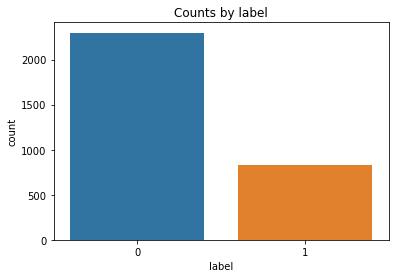

In [200]:
sns.countplot(data=data, x='label')
plt.title('Counts by label')

# L1: первичный анализ данных, очищение данных

## 1. Пропуски и дубликаты

In [201]:
data[data.isnull().any(axis=1)]
# пропусков нет

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label


In [202]:
# смотрим полное совпадение, потому что строки могут совпадать частично
data = data[data.duplicated() == False].reset_index(drop=True)
data.shape
# удалилась 1 строка -> все было не зря

(3122, 13)

## 2. Исследуем не уникальные id_i и тексты комментариев
Возможно, будет какая-нибудь тенденция или получится восстановить смысл id_i 
Итоговые таблицы содержат дубликаты по id_i или тексту, количество фейковых (1) или реальных (0) комментариев по дублирующимся id_i или тексту; также поля only_fake (если все комментарий для дублирующихся id_i фейковые) и only_real (если все комментарий для дублирующихся id_i реальные)

In [203]:
print('unique id1: ', data.id1.nunique())
print('unique id2: ', data.id2.nunique())
print('unique id3: ', data.id3.nunique())
print('unique text: ', data.text.nunique())

print('data.shape: ', data.shape[0])

unique id1:  3049
unique id2:  3006
unique id3:  978
unique text:  3078
data.shape:  3122


In [204]:
# id1
id1_dupl = data[data.duplicated(subset='id1', keep=False)==True].sort_values('id1')


id1_dupl_group = id1_dupl.groupby(['id1', 'label']).count().reset_index().sort_values(['id1', 'label'])\
                                    .pivot(columns='label' , index='id1', values='f1').reset_index()
id1_dupl_group.columns = ['id1', '0', '1']
id1_dupl_group.fillna(0, inplace=True)
id1_dupl_group['only_fake'] = id1_dupl_group['0'] ==0
id1_dupl_group['only_real'] = id1_dupl_group['1'] ==0
id1_dupl_group

,id1,0,1,only_fake,only_real
0,283707312858959120,0.0,3.0,True,False
1,709978154103824154,0.0,4.0,True,False
2,3219492227731060618,0.0,4.0,True,False
3,3708867479137605805,0.0,2.0,True,False
4,3884959853494955383,2.0,0.0,False,True
5,4031770534571429755,1.0,1.0,False,False
6,4321680693964345575,2.0,0.0,False,True
7,5002269436549863957,4.0,11.0,False,False
8,5342274323283053559,0.0,2.0,True,False
9,5808270878095280857,0.0,2.0,True,False


In [205]:
print('Процент только фейков для дублирующихся id1:', id1_dupl_group.only_fake.sum() / len(id1_dupl_group))
print('Процент только реальных для дублирующихся id1:', id1_dupl_group.only_real.sum() / len(id1_dupl_group))
print('Процент присутствия и реальных, и фейков для дублирующихся id1:', 
      (len(id1_dupl_group) - id1_dupl_group.only_fake.sum() -  id1_dupl_group.only_real.sum()) / len(id1_dupl_group))


Процент только фейков для дублирующихся id1: 0.5
Процент только реальных для дублирующихся id1: 0.3157894736842105
Процент присутствия и реальных, и фейков для дублирующихся id1: 0.18421052631578946


есть 18% дублирующихся id1, для которых есть и фейковые и реальные комментарии

In [206]:
# id2
id2_dupl = data[data.duplicated(subset='id2', keep=False)==True].sort_values('id2')


id2_dupl_group = id2_dupl.groupby(['id2', 'label']).count().reset_index().sort_values(['id2', 'label'])\
                                    .pivot(columns='label' , index='id2', values='f1').reset_index()
id2_dupl_group.columns = ['id2', '0', '1']
id2_dupl_group.fillna(0, inplace=True)
id2_dupl_group['only_fake'] = id2_dupl_group['0'] ==0
id2_dupl_group['only_real'] = id2_dupl_group['1'] ==0
id2_dupl_group

,id2,0,1,only_fake,only_real
0,174383820871552726,0.0,2.0,True,False
1,305024864908772719,0.0,2.0,True,False
2,438285525609445934,2.0,0.0,False,True
3,797017299901186909,2.0,0.0,False,True
4,1493472404294552094,1.0,1.0,False,False
...,...,...,...,...,...
69,17071236827374609681,0.0,2.0,True,False
70,17312677487485542503,0.0,9.0,True,False
71,17507424020636860215,1.0,1.0,False,False
72,17948753558116765421,0.0,6.0,True,False


In [207]:
print('Процент только фейков для дублирующихся id2:', id2_dupl_group.only_fake.sum() / len(id2_dupl_group))
print('Процент только реальных для дублирующихся id2:', id2_dupl_group.only_real.sum() / len(id2_dupl_group))
print('Процент присутствия и реальных, и фейков для дублирующихся id2:', 
      (len(id2_dupl_group) - id2_dupl_group.only_fake.sum() -  id2_dupl_group.only_real.sum()) / len(id2_dupl_group))

Процент только фейков для дублирующихся id2: 0.3108108108108108
Процент только реальных для дублирующихся id2: 0.4594594594594595
Процент присутствия и реальных, и фейков для дублирующихся id2: 0.22972972972972974


есть 22% дублирующихся id2, для которых есть и фейковые и реальные комментарии

In [208]:
# id3
id3_dupl = data[data.duplicated(subset='id3', keep=False)==True].sort_values('id3')


id3_dupl_group = id3_dupl.groupby(['id3', 'label']).count().reset_index().sort_values(['id3', 'label'])\
                                    .pivot(columns='label' , index='id3', values='f1').reset_index()
id3_dupl_group.columns = ['id3', '0', '1']
id3_dupl_group.fillna(0, inplace=True)
id3_dupl_group['only_fake'] = id3_dupl_group['0'] ==0
id3_dupl_group['only_real'] = id3_dupl_group['1'] ==0
id3_dupl_group

,id3,0,1,only_fake,only_real
0,75505668647254912,8.0,1.0,False,False
1,89524856874974827,4.0,1.0,False,False
2,96661188109325683,1.0,1.0,False,False
3,111722113303989306,4.0,2.0,False,False
4,147319039488091070,11.0,1.0,False,False
...,...,...,...,...,...
473,18272523555624245955,2.0,1.0,False,False
474,18284196990624346246,2.0,0.0,False,True
475,18317455755332288094,2.0,0.0,False,True
476,18427686369090007398,2.0,1.0,False,False


In [209]:
print('Процент только фейков для дублирующихся id3:', id3_dupl_group.only_fake.sum() / len(id3_dupl_group))
print('Процент только реальных для дублирующихся id3:', id3_dupl_group.only_real.sum() / len(id3_dupl_group))
print('Процент присутствия и реальных, и фейков для дублирующихся id3:', 
      (len(id3_dupl_group) - id3_dupl_group.only_fake.sum() -  id3_dupl_group.only_real.sum()) / len(id3_dupl_group))


Процент только фейков для дублирующихся id3: 0.03347280334728033
Процент только реальных для дублирующихся id3: 0.4100418410041841
Процент присутствия и реальных, и фейков для дублирующихся id3: 0.5564853556485355


есть 55% дублирующихся id3, для которых есть и фейковые и реальные комментарии

Скорее всего, id3 - информация о продавце (так как самый большой процент и фейков, и реальных для дублирующихся id3; 
и самый малый процент только фейков - логично, так как у одного продавца маловероятно отсутствие реальных отзывов по разным товарам)

id1 - информация о пользователе, так как самый большой процент чисто фейковых отзывов (логично, если мы говорим о ботах)

id2 - информация о товаре


In [210]:
# попробуем с текстом

In [211]:
text_dupl = data[data.duplicated(subset='text', keep=False)==True].sort_values('text')


text_dupl_group = text_dupl.groupby(['text', 'label']).count().reset_index().sort_values(['text', 'label'])\
                                    .pivot(columns='label' , index='text', values='f1').reset_index()
text_dupl_group.columns = ['text', '0', '1']
text_dupl_group.fillna(0, inplace=True)
text_dupl_group['only_fake'] = text_dupl_group['0'] ==0
text_dupl_group['only_real'] = text_dupl_group['1'] ==0
text_dupl_group

,text,0,1,only_fake,only_real
0,Внукам нравится!,2.0,0.0,False,True
1,Все отлично,9.0,0.0,False,True
2,Все отлично!,3.0,0.0,False,True
3,Все хорошо,2.0,0.0,False,True
4,Всё отлично,2.0,0.0,False,True
5,Всё отлично!,3.0,0.0,False,True
6,Всё отлично.,2.0,0.0,False,True
7,Всё хорошо,1.0,1.0,False,False
8,Классный!,2.0,0.0,False,True
9,Не оригинал,0.0,2.0,True,False


In [212]:
print('Процент только фейков:', text_dupl_group.only_fake.sum() / len(text_dupl_group))
print('Процент только реальных:', text_dupl_group.only_real.sum() / len(text_dupl_group))
print('Процент присутствия и реальных, и фейков:', 
      (len(text_dupl_group) - text_dupl_group.only_fake.sum() -  text_dupl_group.only_real.sum()) / len(text_dupl_group))

Процент только фейков: 0.14285714285714285
Процент только реальных: 0.5714285714285714
Процент присутствия и реальных, и фейков: 0.2857142857142857


29% дублирующихся отзывов (все дубликаты короткие), которые являются и фейковыми, и реальными - сам текст вряд ли является "решающим" признаком для определения метки комментария - необходимы числовые f1-f8

## 3. Исследуем числовые признаки

In [213]:
df_num = data.drop(['id1', 'id2', 'id3', 'text'], axis=1)

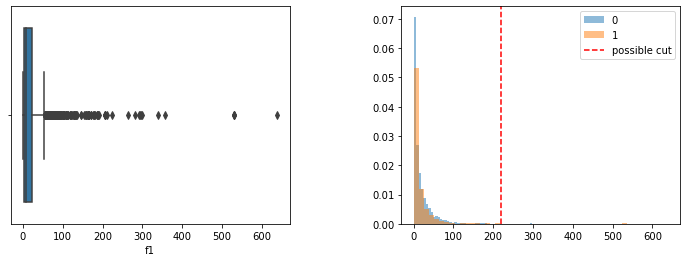

In [214]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f1')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f1[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f1[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4) 
plt.axvline(x=220 , color = 'red', linestyle='--', label='possible cut')
plt.legend()
plt.show()
plt.close('all') 

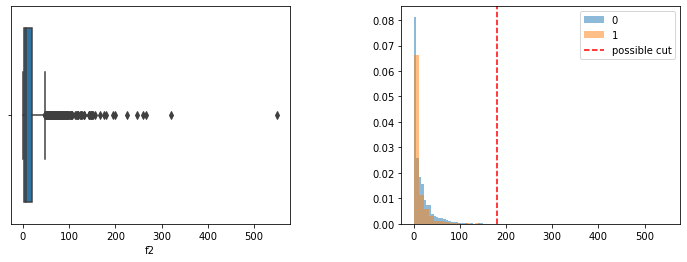

In [215]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f2')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f2[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f2[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
plt.axvline(x=180 , color = 'red', linestyle='--', label='possible cut')
plt.legend()
plt.show()
plt.close('all')

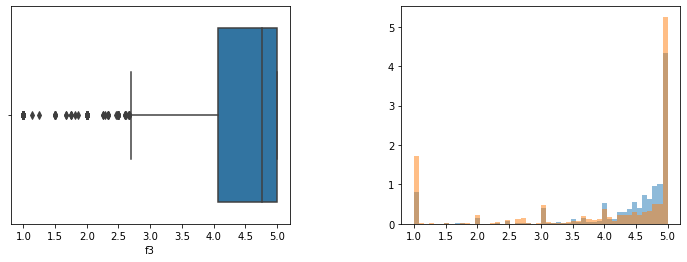

In [216]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f3')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f3[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f3[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
# plt.axvline(x=120 , color = 'red', linestyle='--', label='possible cut')
# plt.legend()
plt.show()
plt.close('all') 

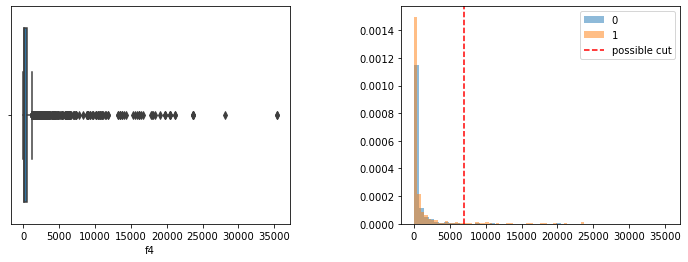

In [217]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f4')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f4[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f4[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
plt.axvline(x=7000 , color = 'red', linestyle='--', label='possible cut')
plt.legend()
plt.show()
plt.close('all') 

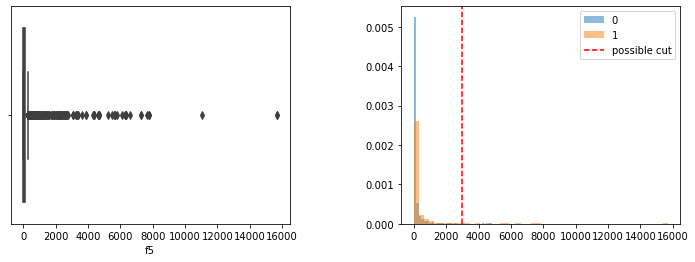

In [218]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f5')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f5[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f5[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
plt.axvline(x=3000 , color = 'red', linestyle='--', label='possible cut')
plt.legend()
plt.show()
plt.close('all')

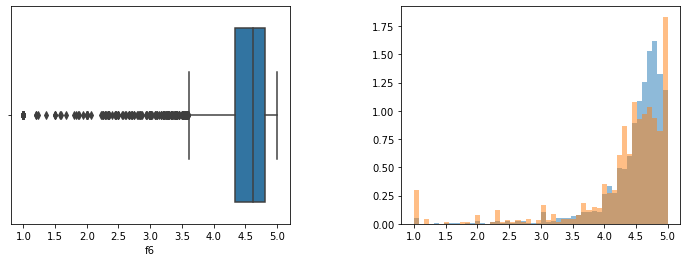

In [219]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f6')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f6[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f6[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
# plt.axvline(x=120 , color = 'red', linestyle='--', label='possible cut')
# plt.legend()
plt.show()
plt.close('all')

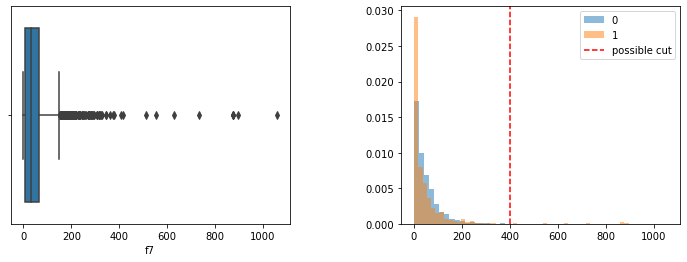

In [220]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f7')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f7[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f7[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
plt.axvline(x=400 , color = 'red', linestyle='--', label='possible cut')
plt.legend()
plt.show()
plt.close('all')

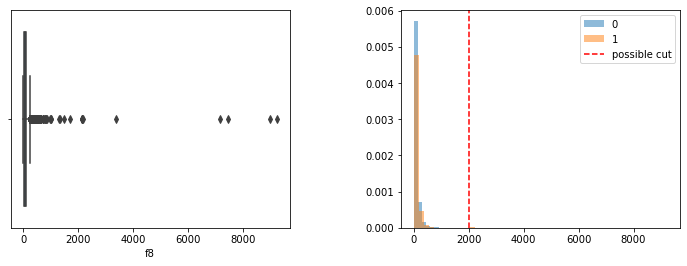

In [221]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_num, x='f8')
ax2 = plt.subplot(1,2,2)
plt.hist(df_num.f8[df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
plt.hist(df_num.f8[df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
plt.subplots_adjust(wspace=0.4)
plt.axvline(x=2000 , color = 'red', linestyle='--', label='possible cut')
plt.legend()
plt.show()
plt.close('all')

### 3.1 Добавим к исходным признакам умножение и деление

In [222]:
cols = list(df_num.columns)
cols.remove('label')
print(cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']


In [223]:
# количество нулевых значений по f_i
for i in cols:
    print(i, ':', len(df_num[i][df_num[i] == 0]))

f1 : 0
f2 : 0
f3 : 0
f4 : 0
f5 : 263
f6 : 0
f7 : 123
f8 : 0


In [224]:
# не осуществляем деление на f_i, у которых есть нулевые элементы
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if len(df_num[cols[j]][df_num[cols[j]]==0].values) == 0:
            name = 'div_' + cols[i] + '_' + cols[j]
            df_num[name] = df_num[cols[i]] / df_num[cols[j]]
        name1 = 'mult_' + cols[i] + '_' + cols[j]
        df_num[name1] = df_num[cols[i]] * df_num[cols[j]]

In [225]:
df_num.head(2)

,f1,f2,f3,f4,f5,f6,f7,f8,label,div_f1_f2,...,div_f5_f6,mult_f5_f6,mult_f5_f7,div_f5_f8,mult_f5_f8,mult_f6_f7,div_f6_f8,mult_f6_f8,div_f7_f8,mult_f7_f8
0,1,1,1.0,11,13,4.272727,18,36,0,1.000000,...,3.042553,55.545455,234,0.361111,468,76.909091,0.118687,153.818182,0.500000,648
1,10,6,2.7,46,4,4.434783,90,109,1,1.666667,...,0.901961,17.739130,360,0.036697,436,399.130435,0.040686,483.391304,0.825688,9810


In [226]:
df_num_new = df_num.drop(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'], axis=1)

In [227]:
df_num_new.head(2)

,label,div_f1_f2,mult_f1_f2,div_f1_f3,mult_f1_f3,div_f1_f4,mult_f1_f4,mult_f1_f5,div_f1_f6,mult_f1_f6,...,div_f5_f6,mult_f5_f6,mult_f5_f7,div_f5_f8,mult_f5_f8,mult_f6_f7,div_f6_f8,mult_f6_f8,div_f7_f8,mult_f7_f8
0,0,1.000000,1,1.000000,1.0,0.090909,11,13,0.234043,4.272727,...,3.042553,55.545455,234,0.361111,468,76.909091,0.118687,153.818182,0.500000,648
1,1,1.666667,60,3.703704,27.0,0.217391,460,40,2.254902,44.347826,...,0.901961,17.739130,360,0.036697,436,399.130435,0.040686,483.391304,0.825688,9810


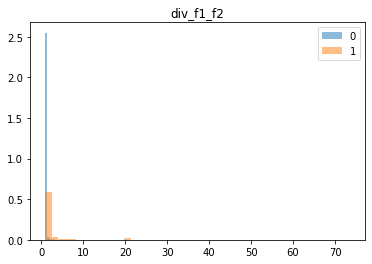

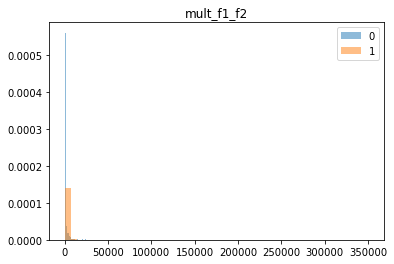

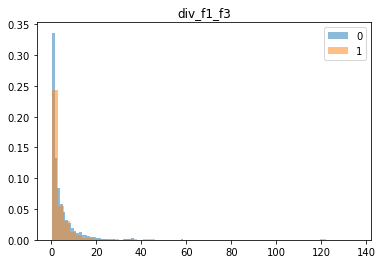

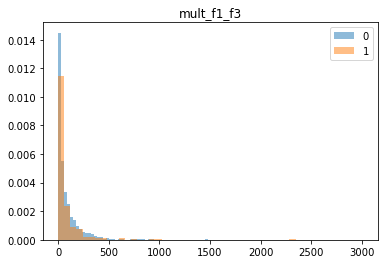

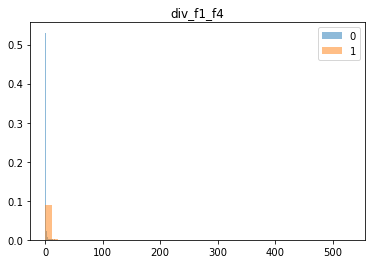

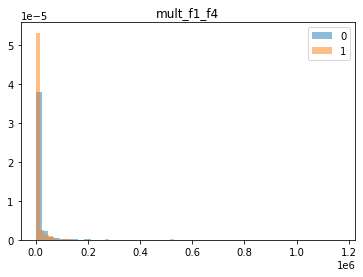

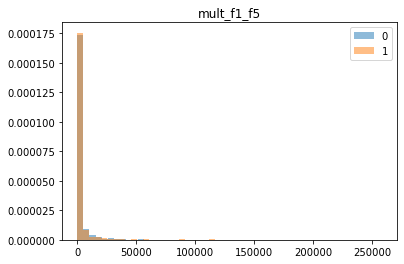

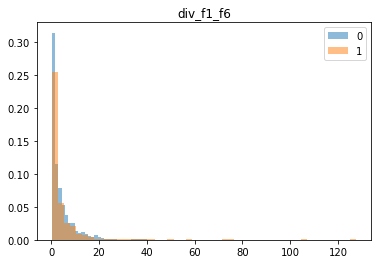

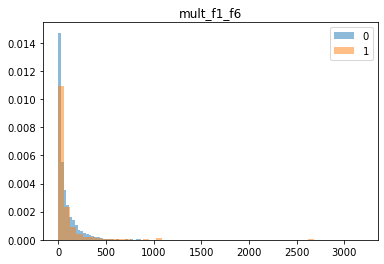

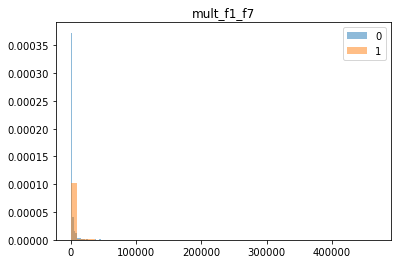

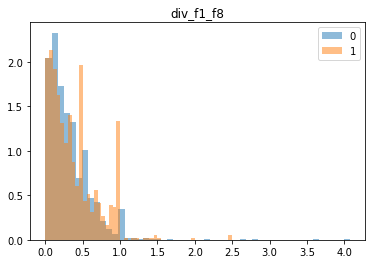

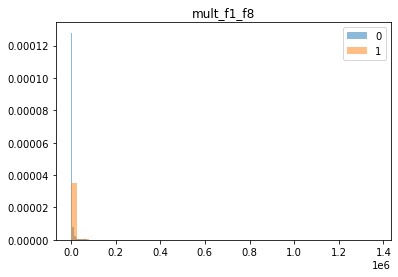

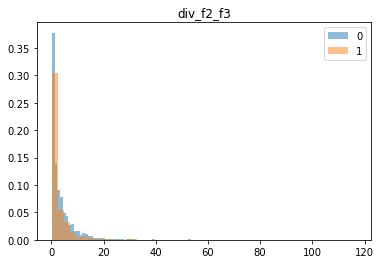

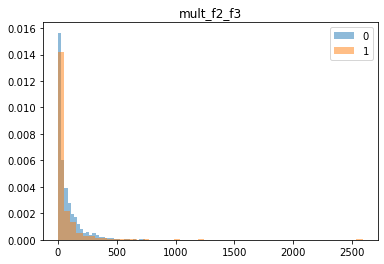

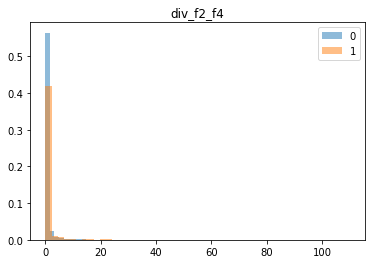

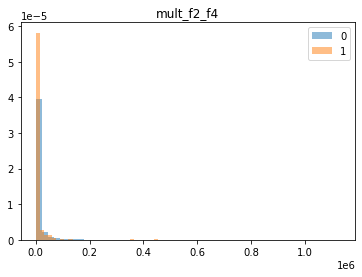

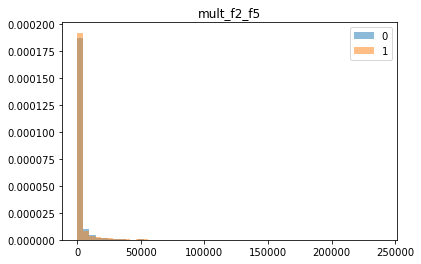

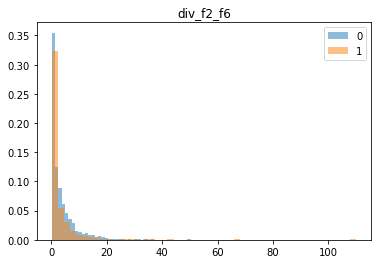

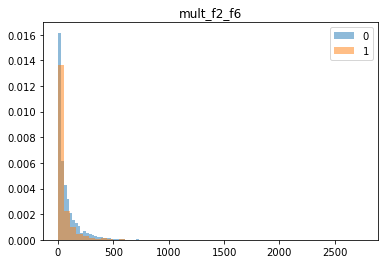

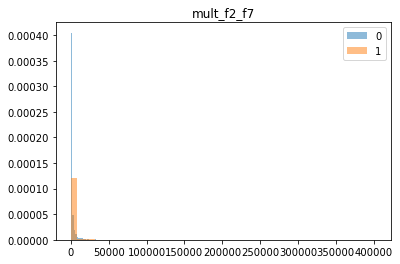

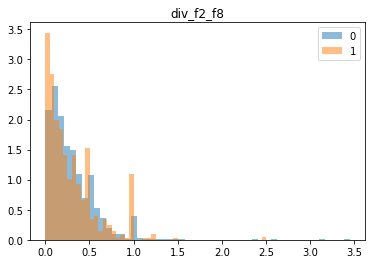

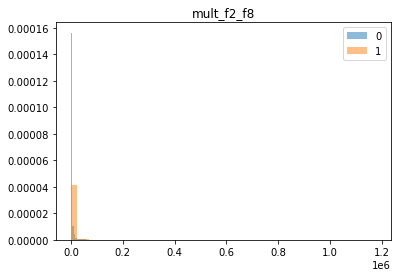

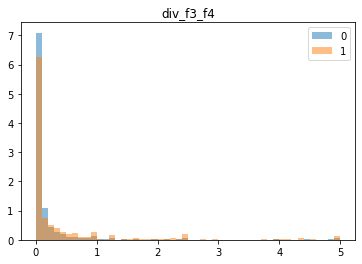

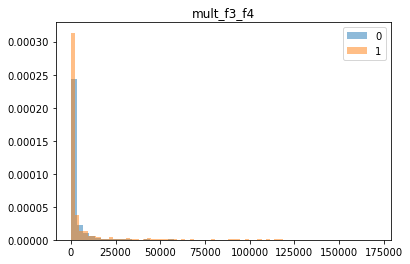

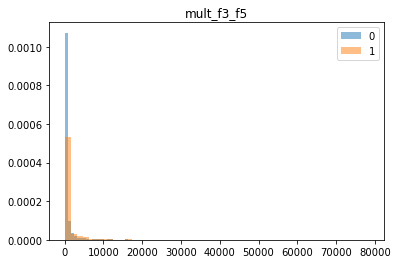

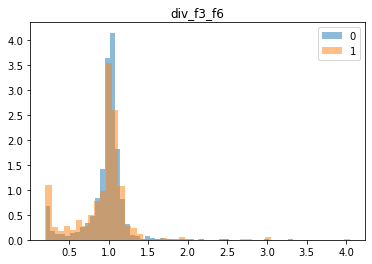

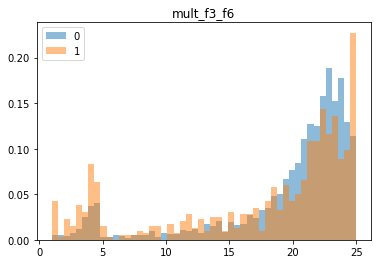

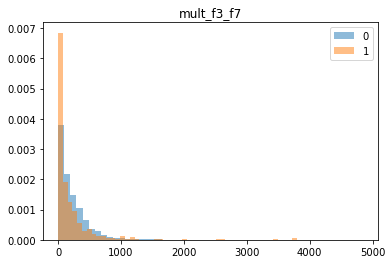

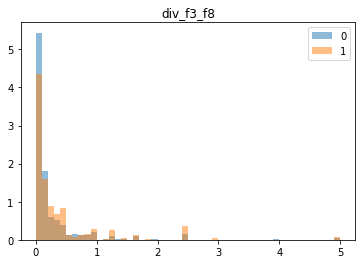

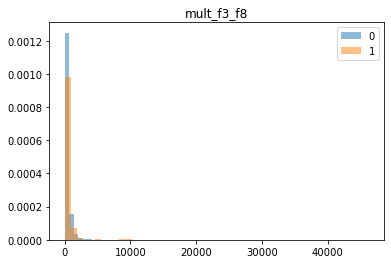

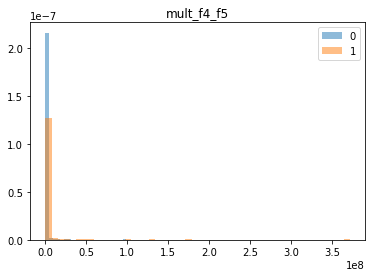

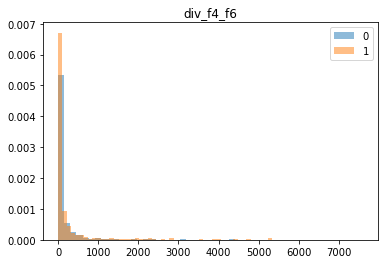

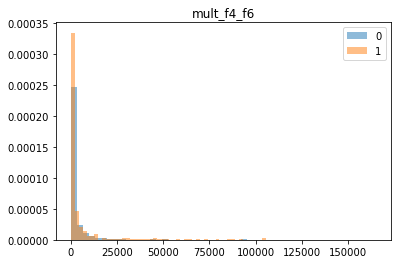

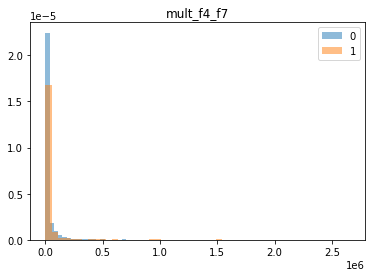

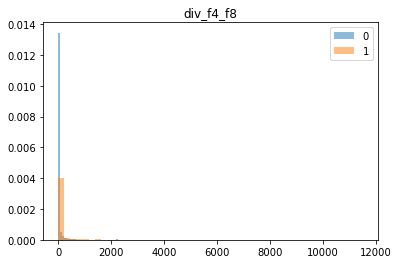

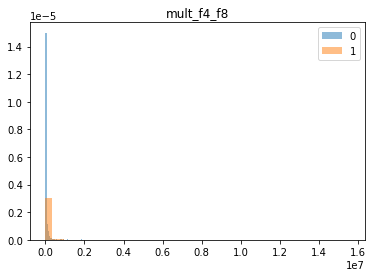

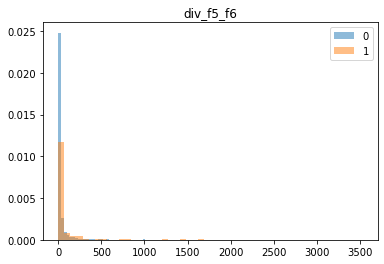

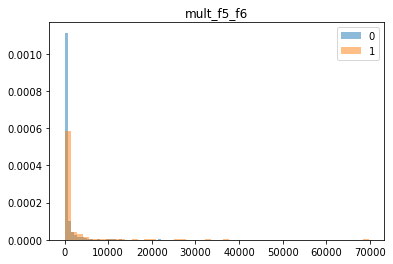

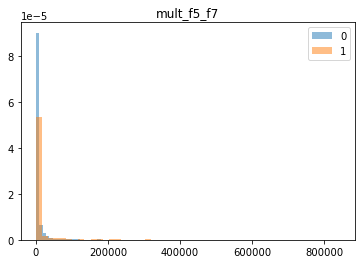

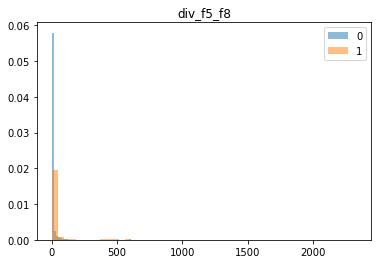

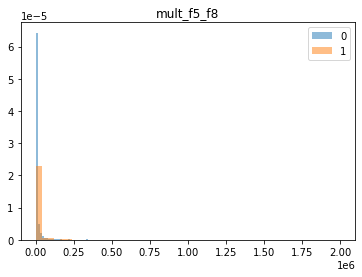

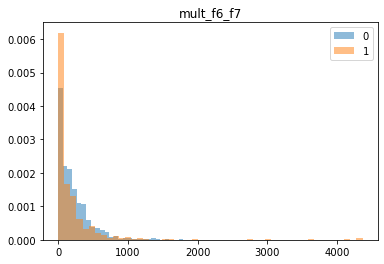

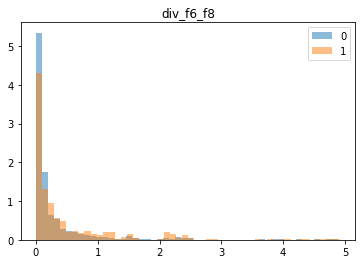

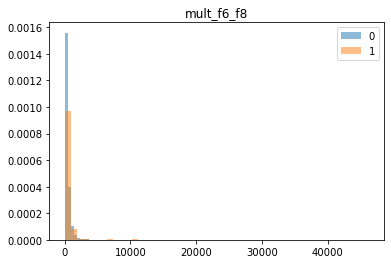

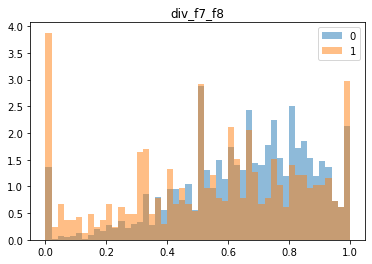

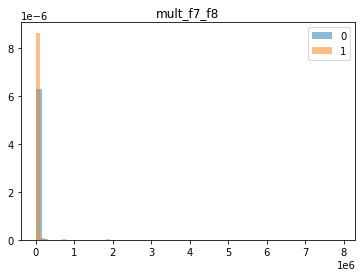

In [228]:
cols = list(df_num_new.columns)
cols.remove('label')

for i in cols:
    plt.hist(df_num_new[i][df_num_new.label == 0], label='0', bins=50, alpha=0.5, density=True)
    plt.hist(df_num_new[i][df_num_new.label == 1], label='1', bins=50, alpha=0.5, density=True)
    plt.legend()
    plt.title(i)
    plt.show()

In [229]:
df_num

,f1,f2,f3,f4,f5,f6,f7,f8,label,div_f1_f2,...,div_f5_f6,mult_f5_f6,mult_f5_f7,div_f5_f8,mult_f5_f8,mult_f6_f7,div_f6_f8,mult_f6_f8,div_f7_f8,mult_f7_f8
0,1,1,1.000000,11,13,4.272727,18,36,0,1.000000,...,3.042553,55.545455,234,0.361111,468,76.909091,0.118687,153.818182,0.500000,648
1,10,6,2.700000,46,4,4.434783,90,109,1,1.666667,...,0.901961,17.739130,360,0.036697,436,399.130435,0.040686,483.391304,0.825688,9810
2,4,4,4.000000,14,0,4.500000,4,6,0,1.000000,...,0.000000,0.000000,0,0.000000,0,18.000000,0.750000,27.000000,0.666667,24
3,6,6,5.000000,374,30,4.772727,14,15,1,1.000000,...,6.285714,143.181818,420,2.000000,450,66.818182,0.318182,71.590909,0.933333,210
4,19,18,5.000000,6,4,5.000000,26,33,0,1.055556,...,0.800000,20.000000,104,0.121212,132,130.000000,0.151515,165.000000,0.787879,858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,2,2,3.000000,19,1,4.263158,9,9,0,1.000000,...,0.234568,4.263158,9,0.111111,9,38.368421,0.473684,38.368421,1.000000,81
3118,8,8,4.375000,131,83,4.183206,18,18,0,1.000000,...,19.841241,347.206107,1494,4.611111,1494,75.297710,0.232400,75.297710,1.000000,324
3119,13,12,5.000000,145,2,4.944828,12,14,0,1.083333,...,0.404463,9.889655,24,0.142857,28,59.337931,0.353202,69.227586,0.857143,168
3120,3,3,5.000000,205,19,4.648780,103,155,0,1.000000,...,4.087093,88.326829,1957,0.122581,2945,478.824390,0.029992,720.560976,0.664516,15965


### 3.2 Добавим текстовый анализ

In [230]:
data_text = data[['text', 'label']].copy()

In [231]:
data_text

,text,label
0,"Хотела купить на замену старых,по итогу эти у...",0
1,Запах по сравнению с обычным DOVE никакой. Оно...,1
2,"Кабель подошёл, хорошо работает.",0
3,"Восторг! Очень приятный аромат, держится долго...",1
4,Визуально все хорошо. Не пробовали. Купили в п...,0
...,...,...
3117,"Стекло не плохое,но есть один минус на техно с...",0
3118,"Всё пришло запаковано, ничего не сломано. Лучш...",0
3119,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",0
3120,"Спасибо, целая пришла. Хорошо упаковано",0


In [232]:
# количество знаков препининия
data_text['num_points'] = data_text.text.apply(lambda x: x.count(',') + x.count(';') \
                                   + x.count(':')+ x.count('.')+ x.count('!')+ x.count('?')\
                                   + x.count('"')+ x.count("'")+ x.count('/'))

In [233]:
# убираем знаки препинания и все, кроме русского текста
from string import digits, whitespace
import re
import numpy as np

cyrillic_letters = "абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"

def tokenizer(text):
    text = text.replace(',', ' ')
    text = text.replace(':', ' ')
    text = text.replace(';', ' ')
    text = text.replace('.', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('"', ' ')
    text = text.replace("'", ' ')
    text = text.replace('/', ' ')
    allowed_chars = cyrillic_letters + digits + whitespace
    return re.sub("\s\s+", " ", "".join([c for c in text if c in allowed_chars])).strip()

# data.text = data.text.apply(lambda x: tokenizer(x.lower()))
data_text.text = data_text.text.apply(lambda x: tokenizer(x))

In [234]:
#количество слов, начинающихся с большой буквы
def big_letter(x):
    counter = 0
    for word in x.split():
        if word[0].upper() == word[0]:
            counter+=1
    return counter

data_text['num_big_letters'] = data_text.text.apply(lambda x: big_letter(x))
data_text.text = data_text.text.apply(lambda x: x.lower())

In [235]:
def avg_word_len(x): # x - string
    x = x.split()
    lens = []
    if len(x) == 0:
        return 0
    for i in x:
        lens.append(len(i))
    return np.mean(lens)

data_text['num_words'] = data_text.text.apply(lambda x: len(x.split()))

data_text['avg_word_len'] = data_text.text.apply(avg_word_len)

In [236]:
data_text['avg_big_letters'] = data_text.num_big_letters / data_text.num_words
data_text['avg_points'] = data_text.num_points / data_text.num_words


# заполнение nan
data_text = data_text.fillna(0)

In [237]:
cols = list(data_text.columns)
cols.remove('text')
cols.remove('label')
cols

['num_points',
 'num_big_letters',
 'num_words',
 'avg_word_len',
 'avg_big_letters',
 'avg_points']

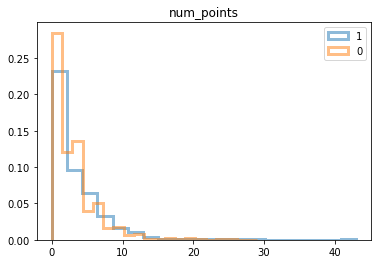

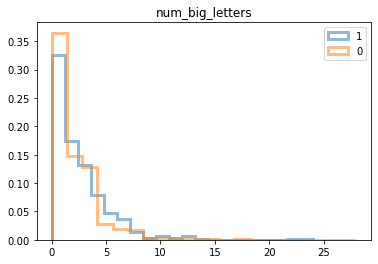

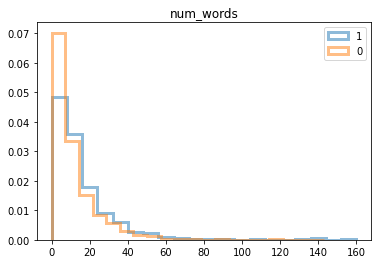

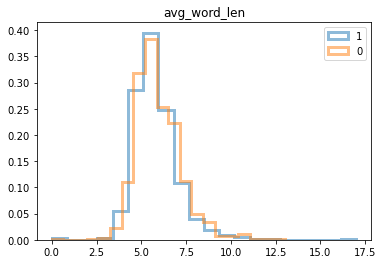

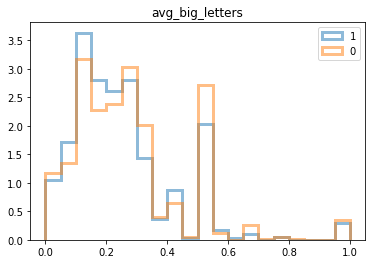

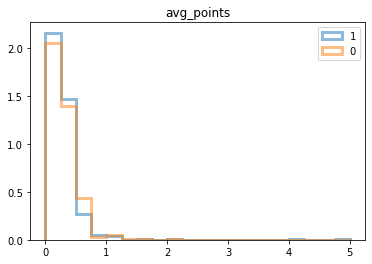

In [238]:
for column in cols:
    plt.hist(data_text[column][data_text.label==1], bins=20, alpha=0.5, label='1', density=True, histtype = 'step', linewidth=3)
    plt.hist(data_text[column][data_text.label==0], bins=20, alpha=0.5, label='0', density=True, histtype = 'step', linewidth=3)
    plt.title(column)
    plt.legend()
    plt.show()

### 

In [248]:
data_new = pd.concat([data_text, df_num], axis=1)

In [249]:
data_new.drop(['text', 'label'], axis=1, inplace=True)

In [250]:
data_new.head(2)

,num_points,num_big_letters,num_words,avg_word_len,avg_big_letters,avg_points,f1,f2,f3,f4,...,div_f5_f6,mult_f5_f6,mult_f5_f7,div_f5_f8,mult_f5_f8,mult_f6_f7,div_f6_f8,mult_f6_f8,div_f7_f8,mult_f7_f8
0,5,1,16,4.750000,0.062500,0.312500,1,1,1.0,11,...,3.042553,55.545455,234,0.361111,468,76.909091,0.118687,153.818182,0.500000,648
1,2,3,14,5.642857,0.214286,0.142857,10,6,2.7,46,...,0.901961,17.739130,360,0.036697,436,399.130435,0.040686,483.391304,0.825688,9810


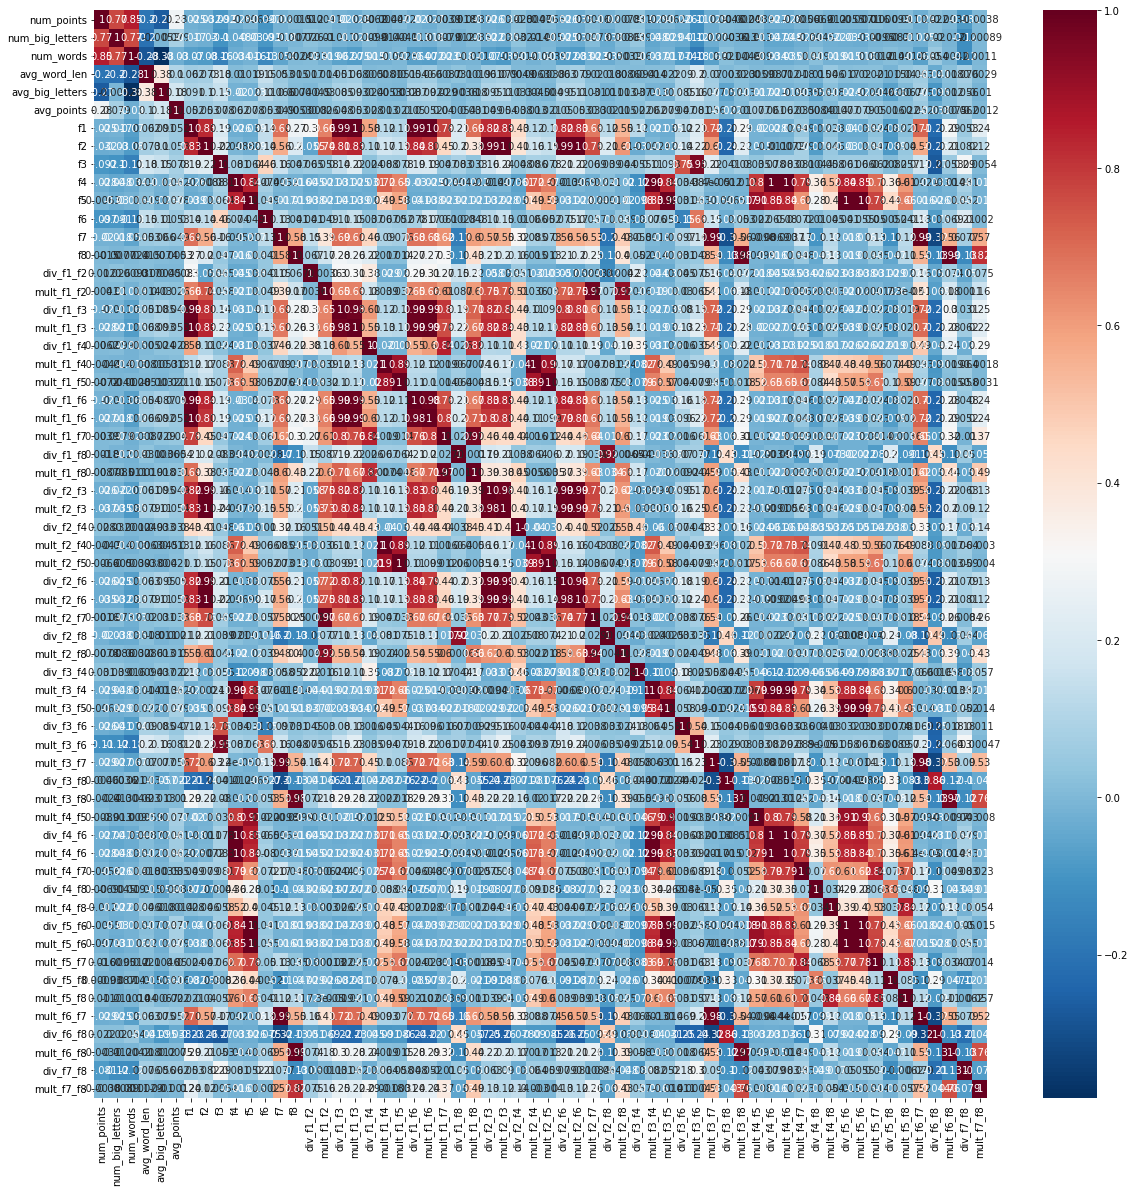

In [253]:
# корреляция при ~0.7
plt.figure(figsize=(20,20))
corr_matrix = data_new.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

# сильно коррелируют f1-f2 и f7-f8

In [258]:
# без умножения признаков
cols = list(data_new.columns)
for i in list(data_new.columns):
    if 'mult_' not in i:
        cols.remove(i)

data_no_mult = data_new.drop(cols, axis=1)

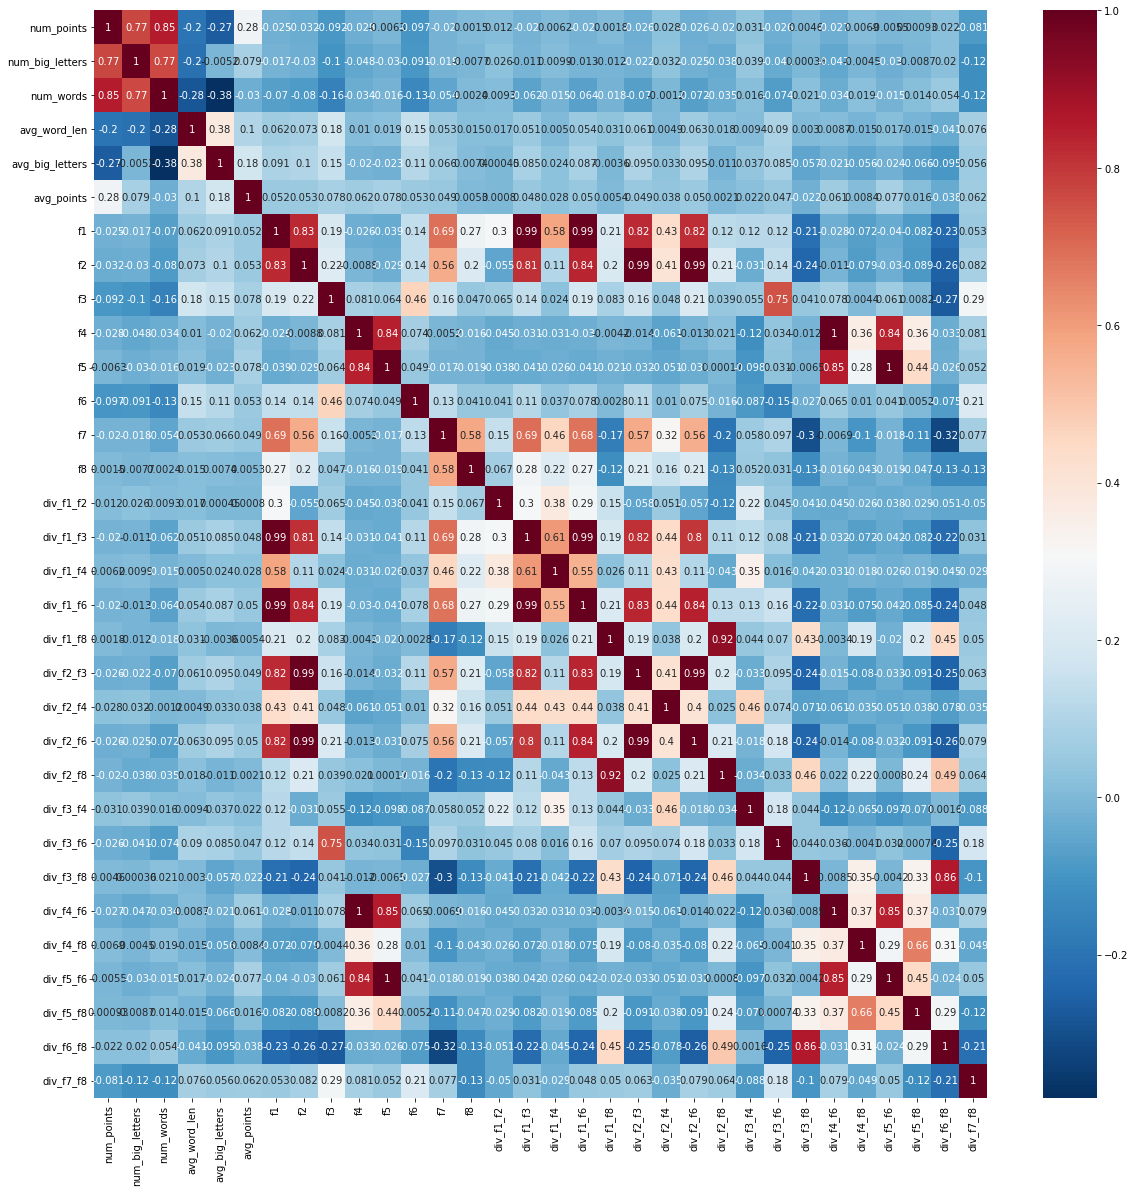

In [260]:
plt.figure(figsize=(20,20))
corr_matrix = data_no_mult.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [ ]:
# Видно, что сильно коррелируют текстовые признаки, также есть корреляция некоторых числовых признаков

In [254]:
# влияние каждой численной переменной на предсказание таргета
from sklearn.feature_selection import mutual_info_classif
 
print(mutual_info_classif(data_new, data['label'], random_state=1))
# все признаки из рассмотренных незначительно влияют на предсказание

[0.         0.         0.00199236 0.         0.00198277 0.00635192
 0.02055091 0.02360992 0.02189547 0.02994771 0.01985156 0.02579385
 0.01571729 0.01291929 0.06672208 0.04448671 0.03308068 0.02247508
 0.03186822 0.02346846 0.03354874 0.00795936 0.02149341 0.02337803
 0.03571773 0.02057434 0.03923278 0.03841303 0.02942404 0.01654922
 0.02116411 0.00985838 0.01270795 0.02871579 0.03041354 0.02387277
 0.02700781 0.03783428 0.03624907 0.04042351 0.04818363 0.02735651
 0.03409797 0.03382339 0.02840801 0.02202388 0.03501707 0.03313031
 0.02780135 0.02058198 0.01747964 0.03993976 0.02321303 0.03426769
 0.02456505 0.03010042 0.02262317 0.03178835 0.04396147 0.03159482]


Вывод: можно попробовать удалить некоторые выбросы: (см. 4-zaretskii-chosen_model_NoOutliers.ipynb)

data = data[data.f1 <220]

data = data[data.f2 <180]

data = data[data.f4 <7000]

data = data[data.f5 <3000]

data = data[data.f7 <400]

data = data[data.f8 <2000]

Текст комментария сам по себе не является хорошим признаком, так как есть одинаковые тексты, которые могут быть и фейком, и реальным комментарием, поэтому необходимо использовать числовые признаки. 

# L2: ресерч проблематики, определение набора подходящих решений

## 2.1 Detecting Spam Reviews on Vietnamese E-commerce Websites
- PhoBERT: f1~87% (monolingual); CNN 77%
- fasttext (viet)
- Text-CNN, LSTM, Transformers
- Based on the results from the training and evaluation of the models, we can see that the classification of the evaluations using the Transformer models gives better performance than the deep neural network models.

## 2.2 Fake reviews classification using deep learning ensemble of shallow convolutions
-  F1 scores of up to 92% 
- Stop words are not removed. NLP techniques such as fltering, stemming and lemmatization are not applied because these techniques could remove the features which are important for classifers [5]. 
- text + other features
- ! ансамбль предсказаний по текстовым признакам (embeddings ) и остальным (в нашем случае - числовым)

## 2.3 Robust Spammer Detection by Nash Reinforcement Learning
- Написано про извлечение текстовых признаков из текста комментария (сделано в L1) -> будет использовано при обучении

Решено попробовать использовать TextCNN с предобработкой текста с помощью трансформера и сделать ансамбль с другой моделью, обученной по числовым признакам (неудачно + мало данных), см. 2.2-zaretskii-Text_CNN-L4.ipynb


Впоследствии решено использовать не сам текст, а его свойства (рассмотренные в L1) и числовые признаки для обучения более простых моделей.  

# L3: формирование обучающей выборки, проектирование валидации

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X = data.drop(['id1', 'id2', 'id3', 'label'], axis=1)
y = data['label']

Text(0.5, 1.0, 'Initial set')

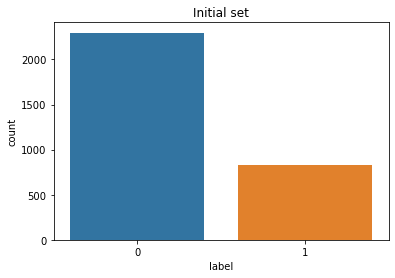

In [41]:
sns.countplot(x=y)
plt.title('Initial set')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=1,
    stratify=y
)

Text(0.5, 1.0, 'Train set')

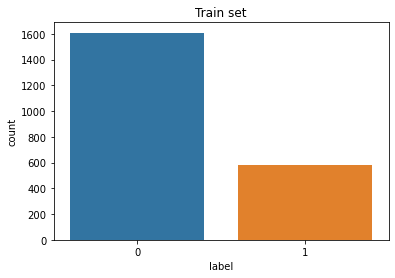

In [43]:
sns.countplot(x=y_train)
plt.title('Train set')

In [44]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, 
    test_size=0.5, 
    random_state=1,
    stratify=y_test
)

Text(0.5, 1.0, 'Validation set')

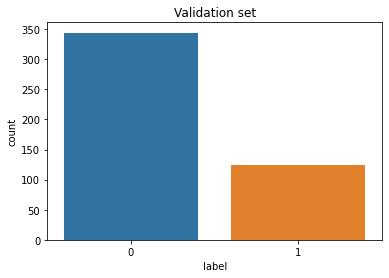

In [45]:
sns.countplot(x=y_val)
plt.title('Validation set')

Text(0.5, 1.0, 'Test set')

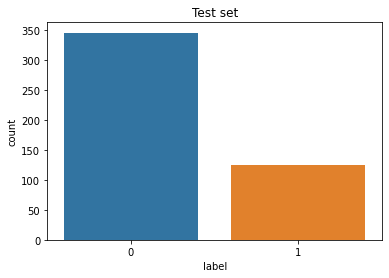

In [46]:
sns.countplot(x=y_test)
plt.title('Test set')

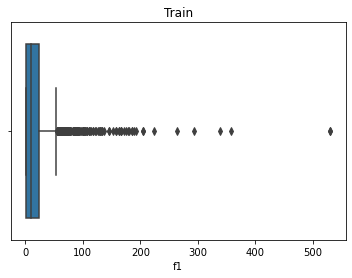

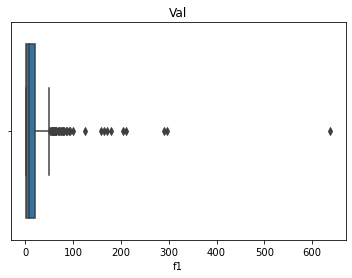

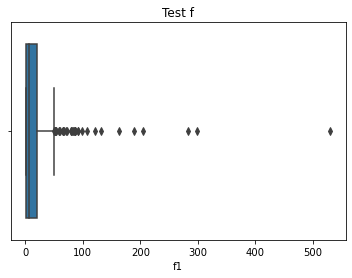

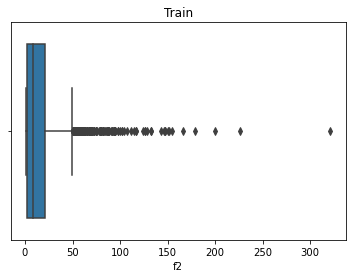

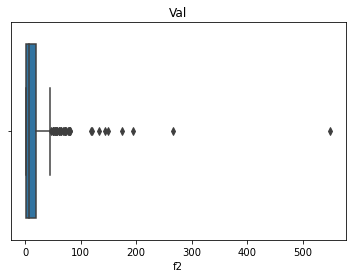

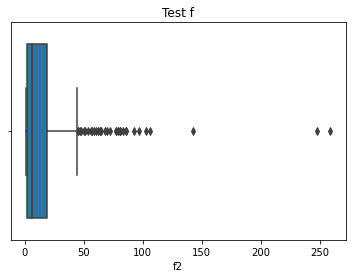

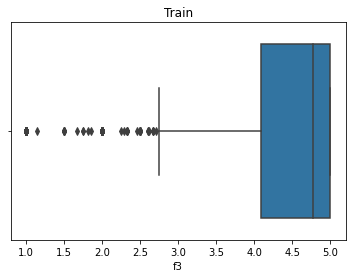

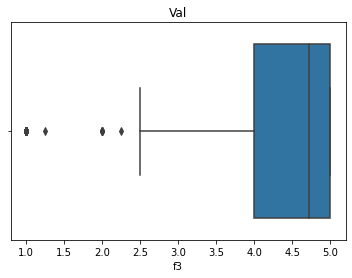

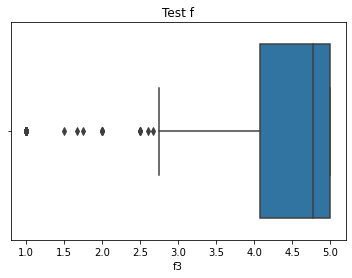

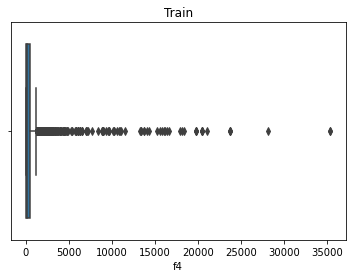

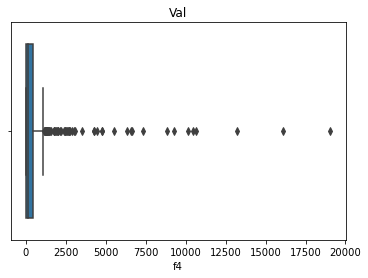

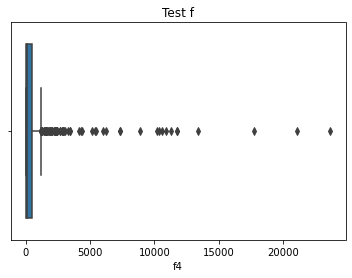

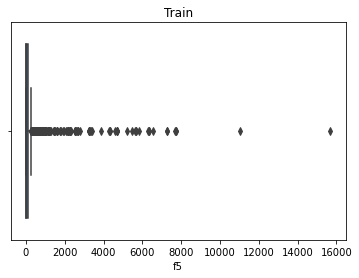

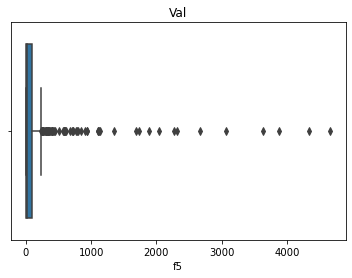

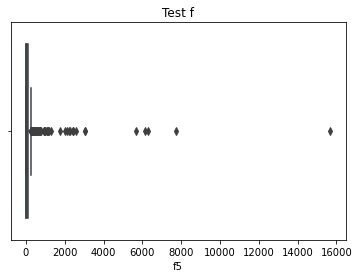

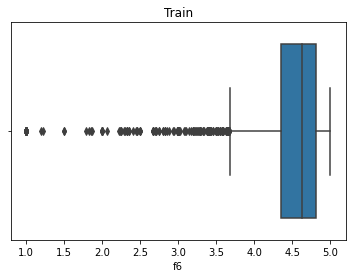

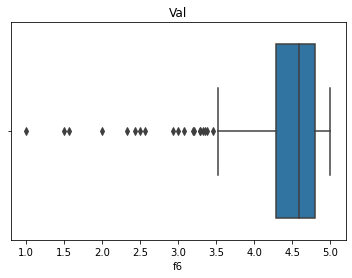

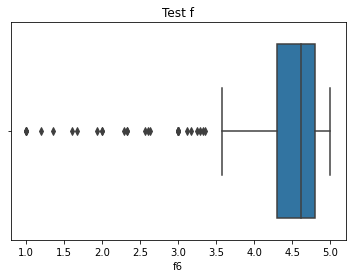

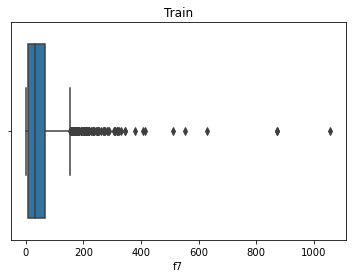

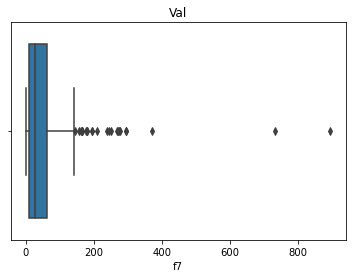

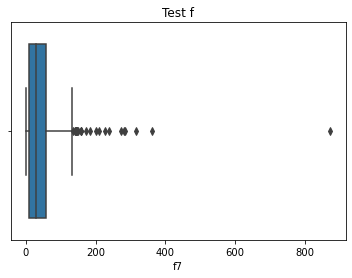

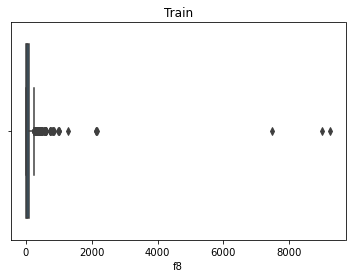

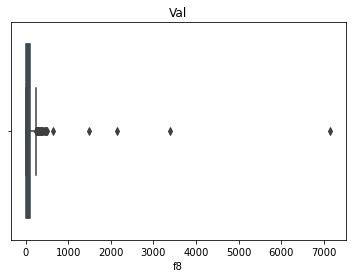

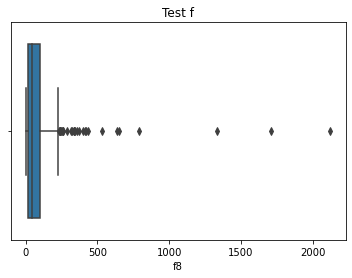

In [47]:
for i in range(1,9):
    sns.boxplot(data=X_train, x='f' + str(i))
    plt.title('Train')
    plt.show()
    sns.boxplot(data=X_val, x='f' + str(i))
    plt.title('Val') 
    plt.show()
    sns.boxplot(data=X_test, x='f' + str(i))
    plt.title('Test f')
    plt.show()